In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization 


# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator


# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


# Other utilities
import sys
import os

Tensorflow/Keras: 2.9.0
numpy: 1.21.6
sklearn: 1.0.2
OpenCV: 4.5.4
matplotlib: 3.5.3
graphviz: 0.8.4


In [20]:

# Specify the location of images after you have downloaded them
ImgLocation="/kaggle/input/flowers/flowers/"

CATEGORIES = set(["rose"])

# Create a list to store image paths
ImagePaths=[]
for category in CATEGORIES:
    for image in list(os.listdir(ImgLocation+category)):
        ImagePaths=ImagePaths+[ImgLocation+category+"/"+image]
        
# Load images and resize to 64 x 64
data_lowres=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lowres = cv2.resize(image, (64, 64))
    data_lowres.append(image_lowres)
    
# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data_lowres = np.array(data_lowres, dtype="float") / 255.0

# Show data shape
print("Shape of data_lowres: ", data_lowres.shape)

Shape of data_lowres:  (999, 64, 64, 3)


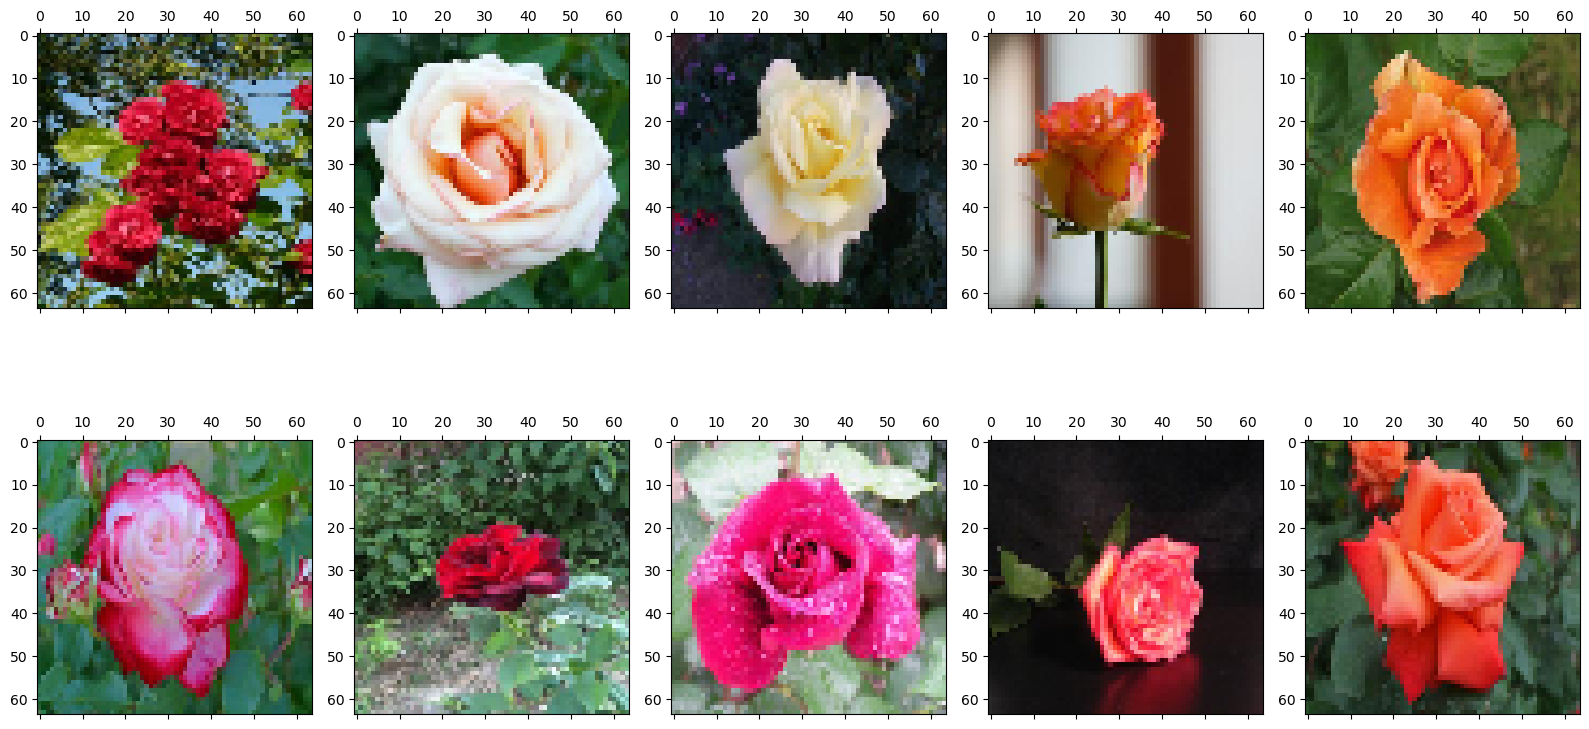

In [21]:
# Display 10 real images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(data_lowres[n])
        n=n+1
plt.show()

In [22]:
# Scaler
scaler=MinMaxScaler(feature_range=(-1, 1))

# Select images that we want to use for model trainng
data=data_lowres.copy()
print("Original shape of the data: ", data.shape)

# Reshape array
data=data.reshape(-1, 1)
print("Reshaped data: ", data.shape)

# Fit the scaler
scaler.fit(data)

# Scale the array
data=scaler.transform(data)

# Reshape back to the original shape
data=data.reshape(data_lowres.shape[0], 64, 64, 3)
print("Shape of the scaled array: ", data.shape)

Original shape of the data:  (999, 64, 64, 3)
Reshaped data:  (12275712, 1)
Shape of the scaled array:  (999, 64, 64, 3)


Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 8192)             827392    
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-Resh  (None, 8, 8, 128)        0         
 ape-1 (Reshape)                                                 
                                                                 
 Generator-Hidden-Layer-2 (C  (None, 16, 16, 128)      262272    
 onv2DTranspose)                                                 
                                                                 
 Generator-Hidden-Layer-Acti  (None, 16, 16, 128)      0         
 vation-2 (ReLU)                                                 
                                                                 
 Generator-Hidden-Layer-3 (C  (None, 32, 32, 256)      52

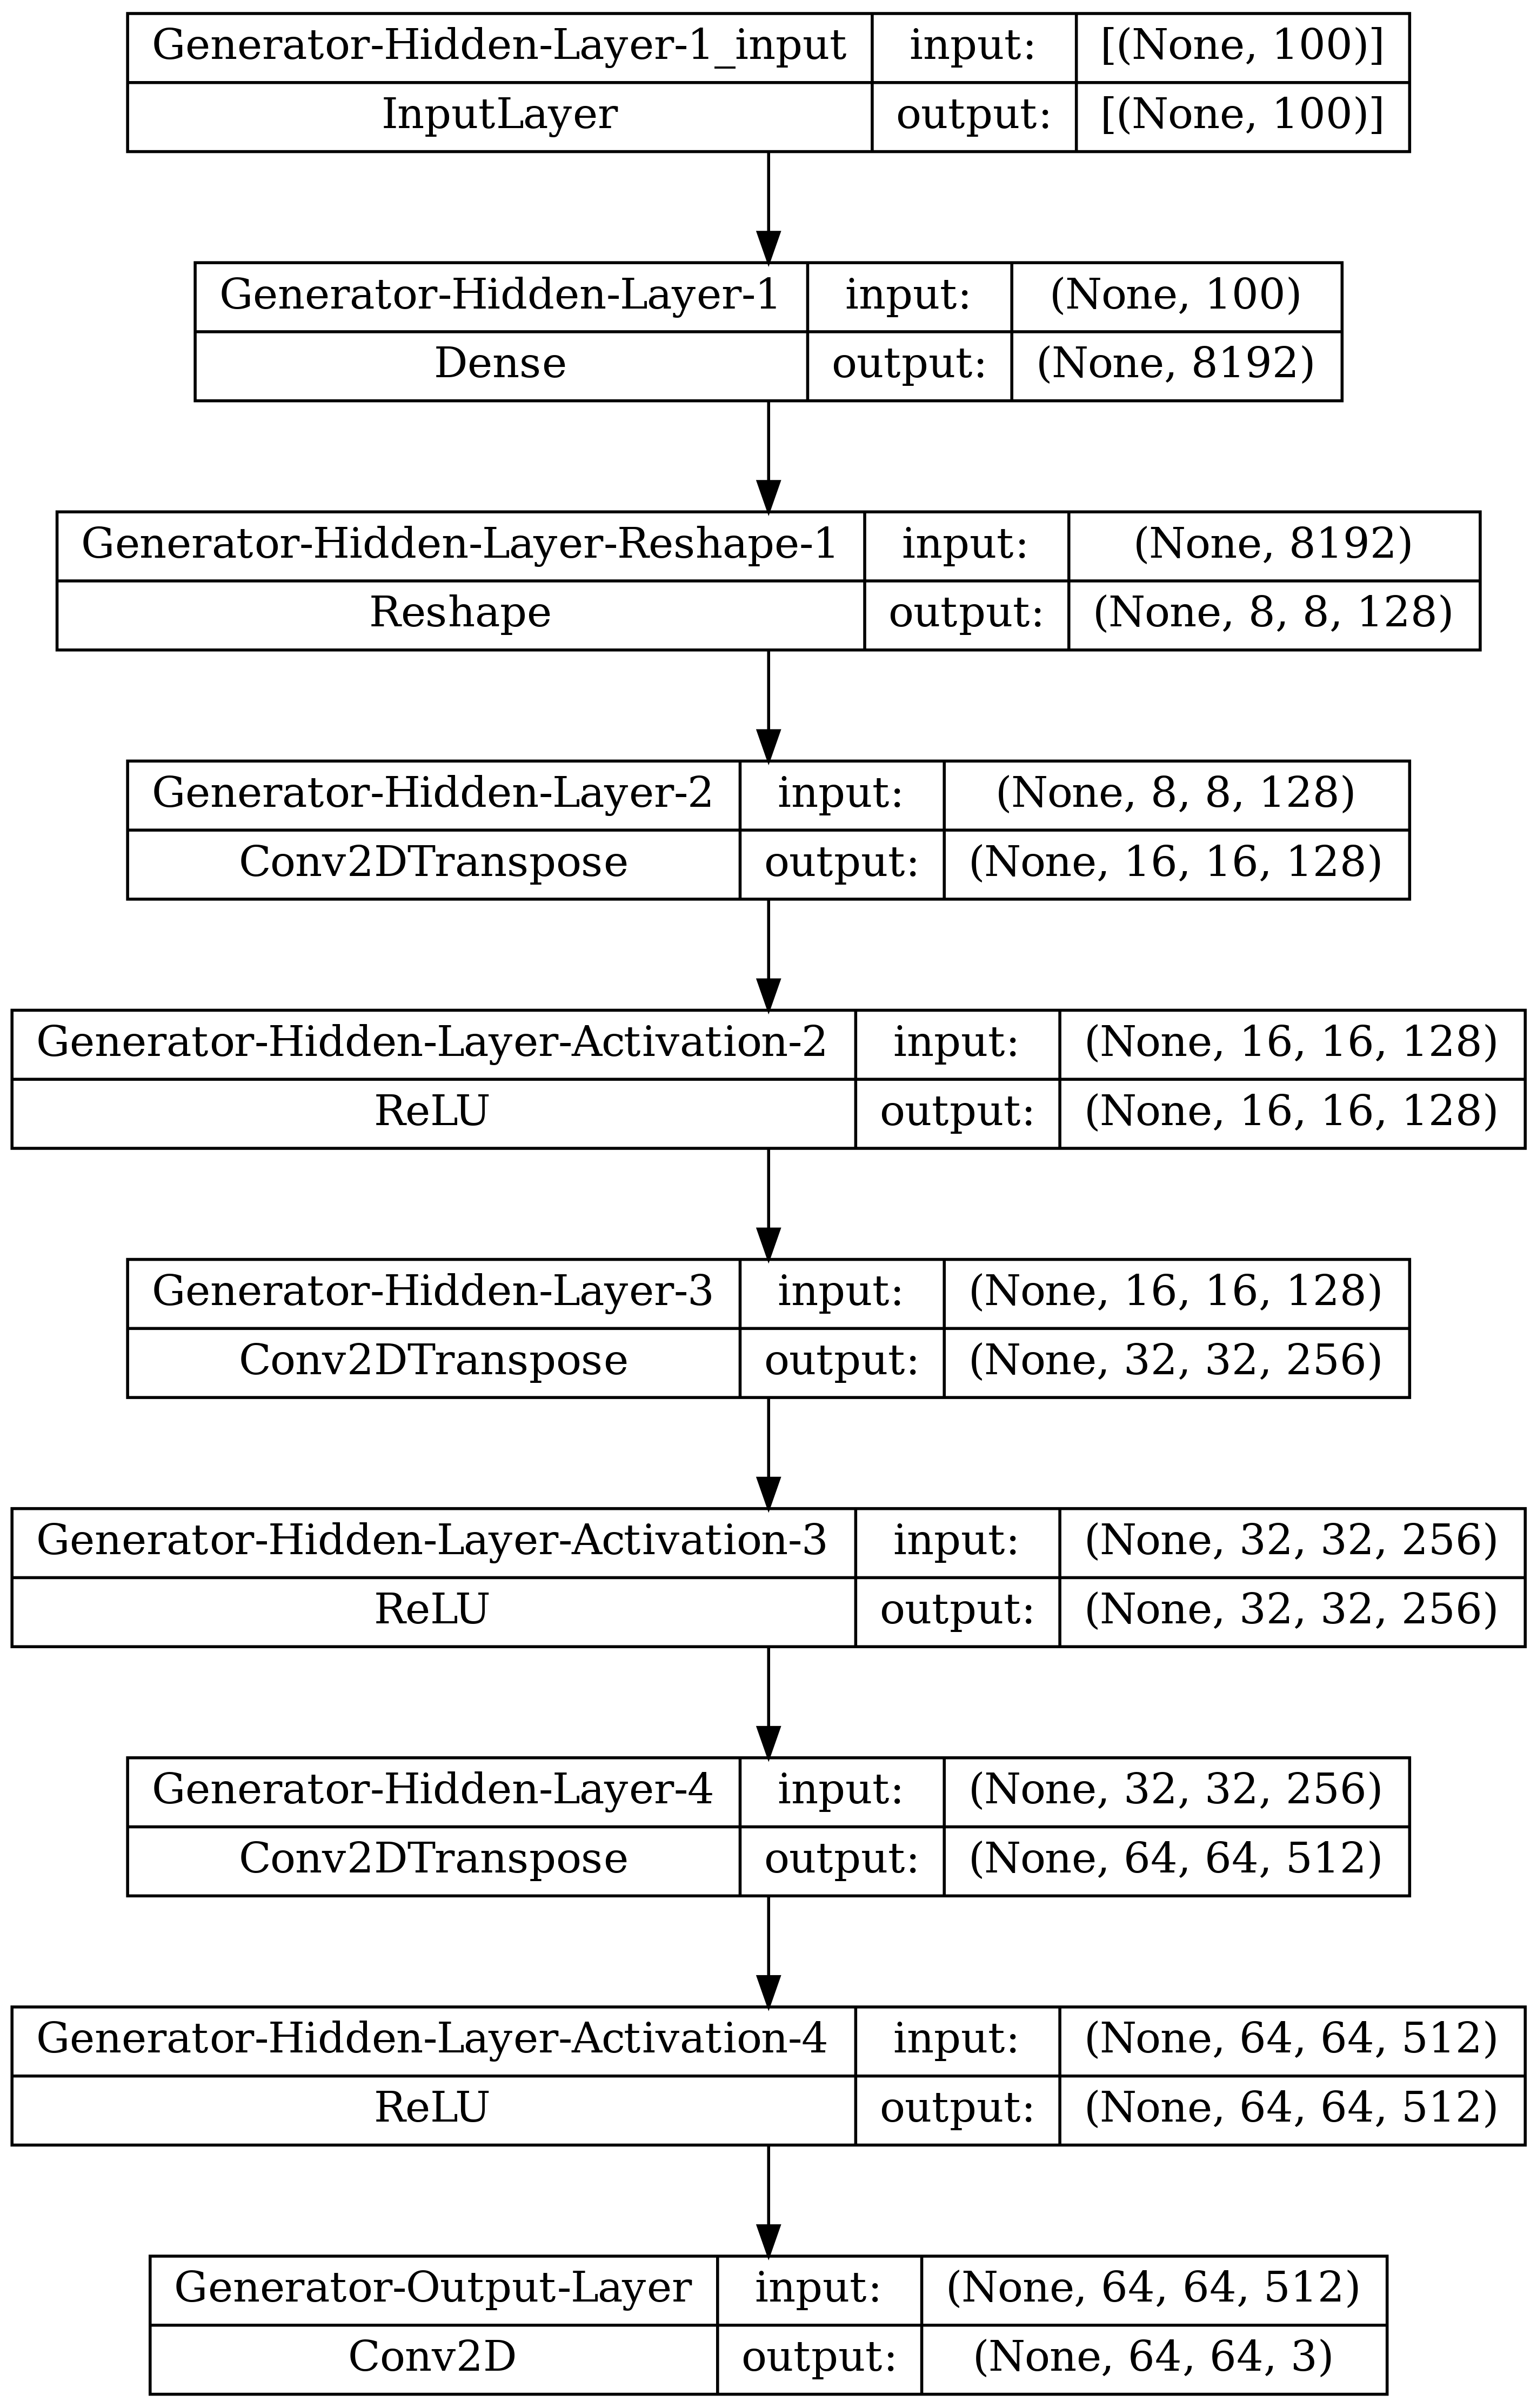

In [23]:
def generator(latent_dim):
    model = Sequential(name="Generator") # Model
    
    # Hidden Layer 1: Start with 8 x 8 image
    n_nodes = 8 * 8 * 128 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_dim=latent_dim, name='Generator-Hidden-Layer-1'))
    model.add(Reshape((8, 8, 128), name='Generator-Hidden-Layer-Reshape-1'))
    
    # Hidden Layer 2: Upsample to 16 x 16
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-2'))
                              
    # Hidden Layer 3: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-3'))
    
    # Hidden Layer 4: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-4'))
    
    # Output Layer (Note, we use 3 filters because we have 3 channels for a color image. Grayscale would have only 1 channel)
    model.add(Conv2D(filters=3, kernel_size=(5,5), activation='tanh', padding='same', name='Generator-Output-Layer'))
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       3136      
 1 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       0         
 Activation-1 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      131200    
 2 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      0         
 Activation-2 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 8, 8, 128)      

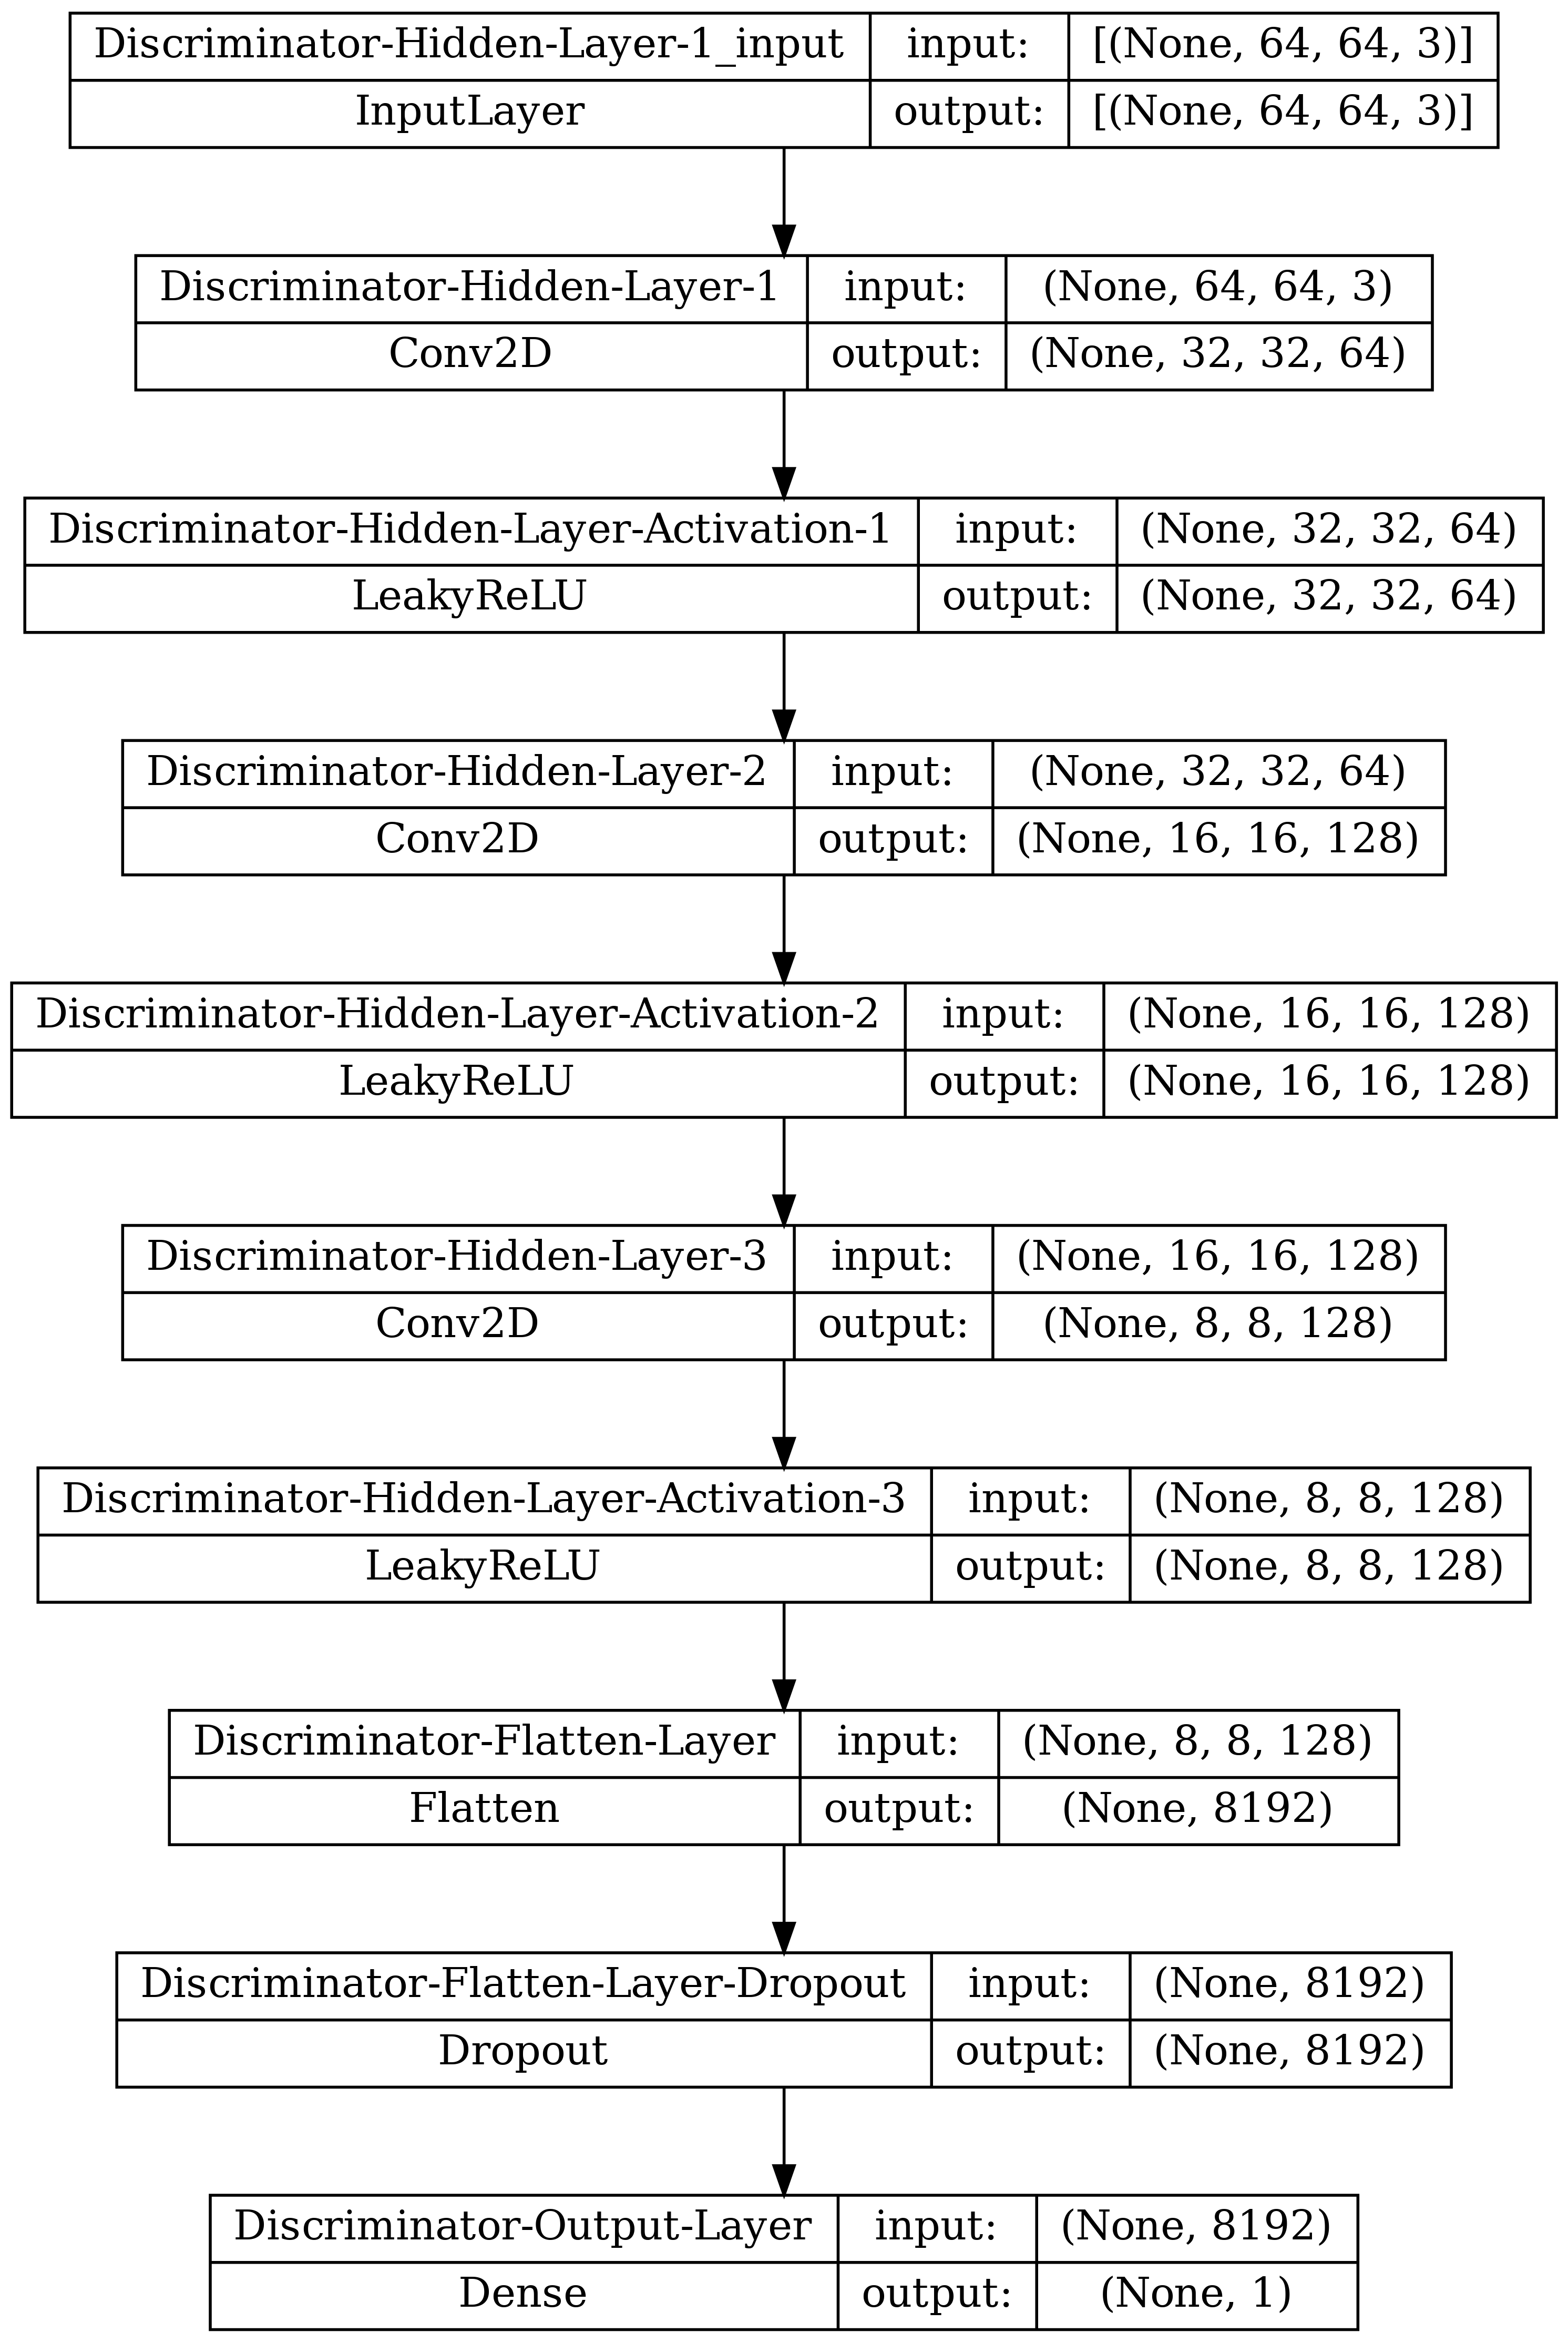

In [24]:
def discriminator(in_shape=(64,64,3)):
    model = Sequential(name="Discriminator") # Model
    
    # Hidden Layer 1
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))
    
    # Hidden Layer 2
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))
    
    # Hidden Layer 3
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))
    
    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400)

Model: "DCGAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 64, 64, 3)         3750275   
                                                                 
 Discriminator (Sequential)  (None, 1)                 404801    
                                                                 
Total params: 4,155,076
Trainable params: 3,750,275
Non-trainable params: 404,801
_________________________________________________________________


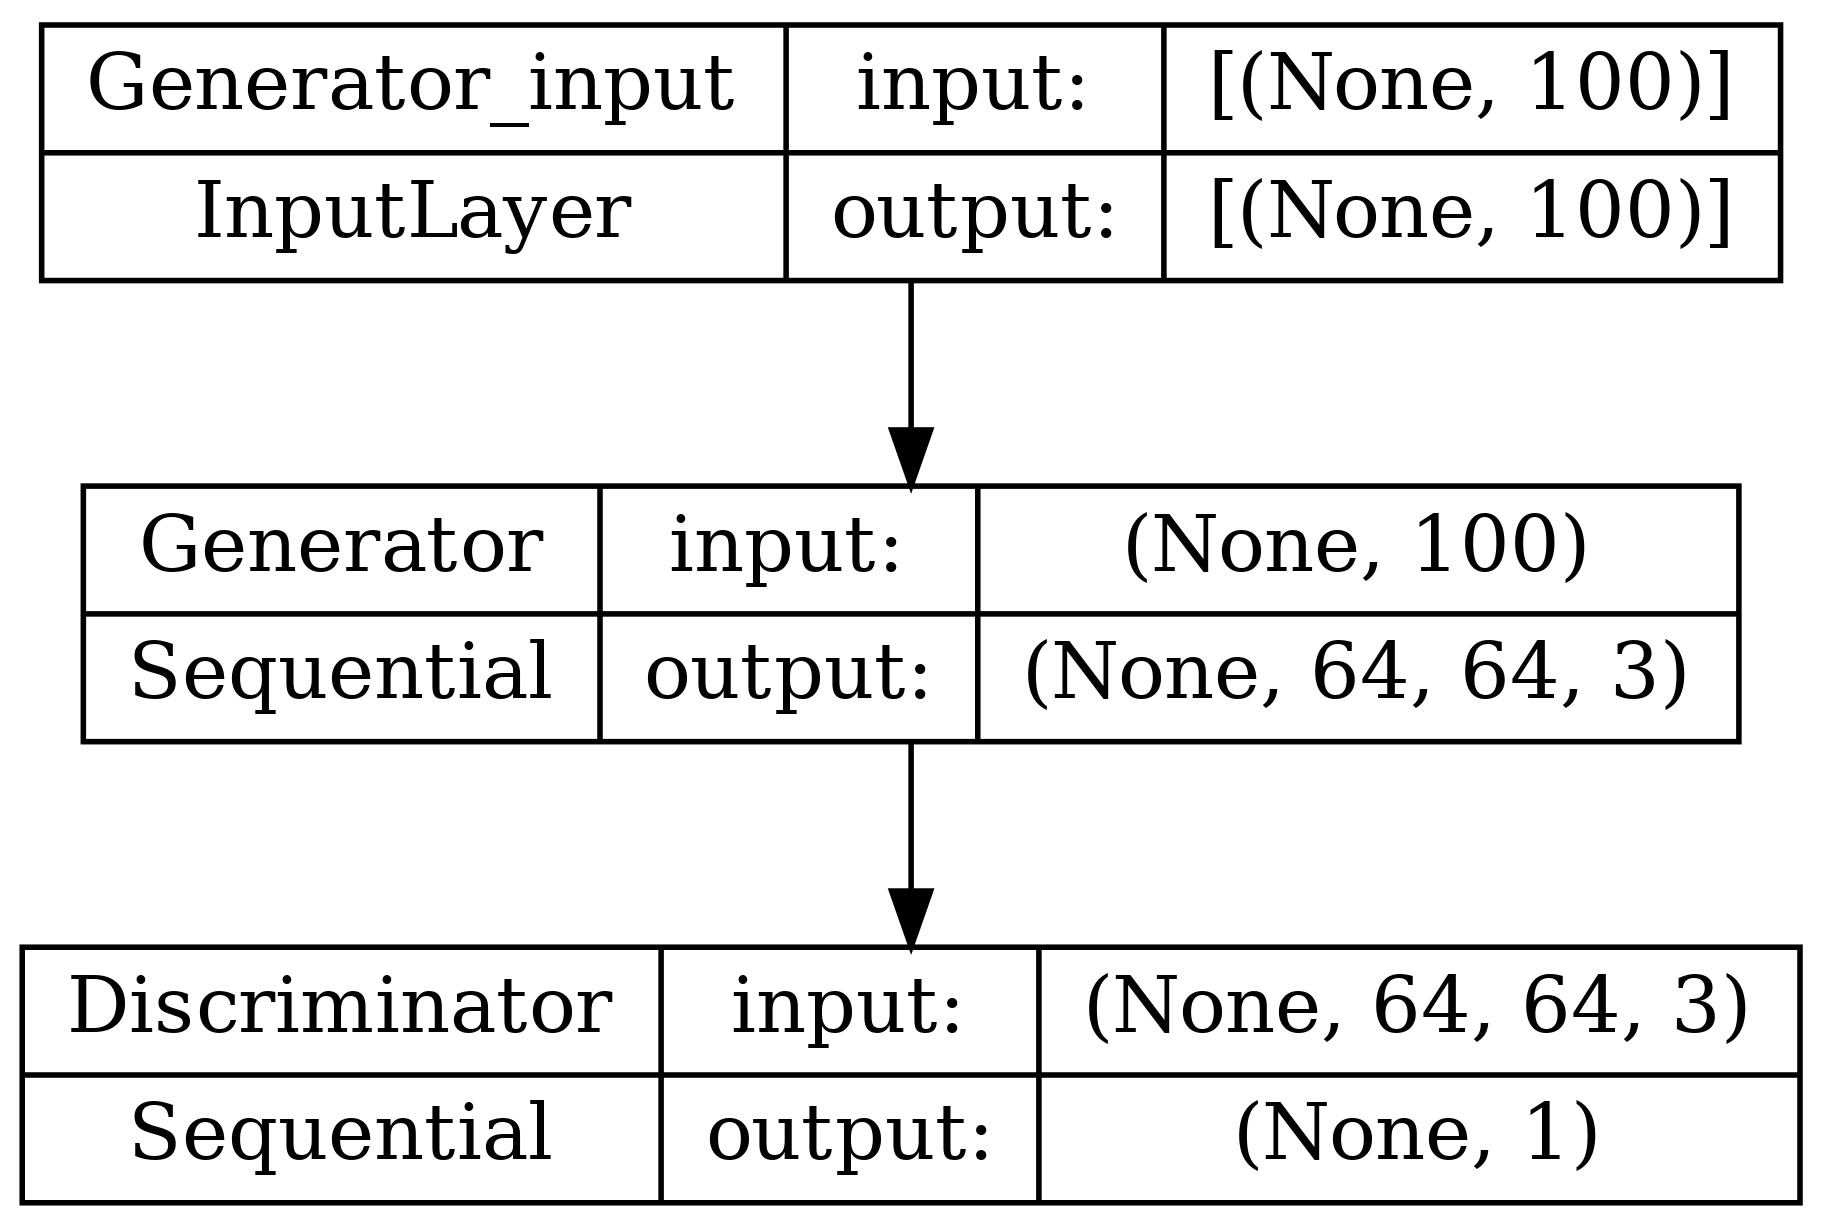

In [25]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Combine
    model = Sequential(name="DCGAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400)

In [26]:
def real_samples(n, dataset):
    
    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))
    return X, y
    
    
def latent_vector(latent_dim, n):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input
  
    
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)
    
    # Create class labels
    y = np.zeros((n, 1))
    return X, y    

In [27]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    
    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)
    
    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show() 

In [28]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1001, n_batch=32, n_eval=100):
    
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)
    
    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

1/1 [==============================] - 2s 2s/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.6910067796707153
Generator Loss:  0.6931042075157166
2/2 [==============================] - 5s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.0


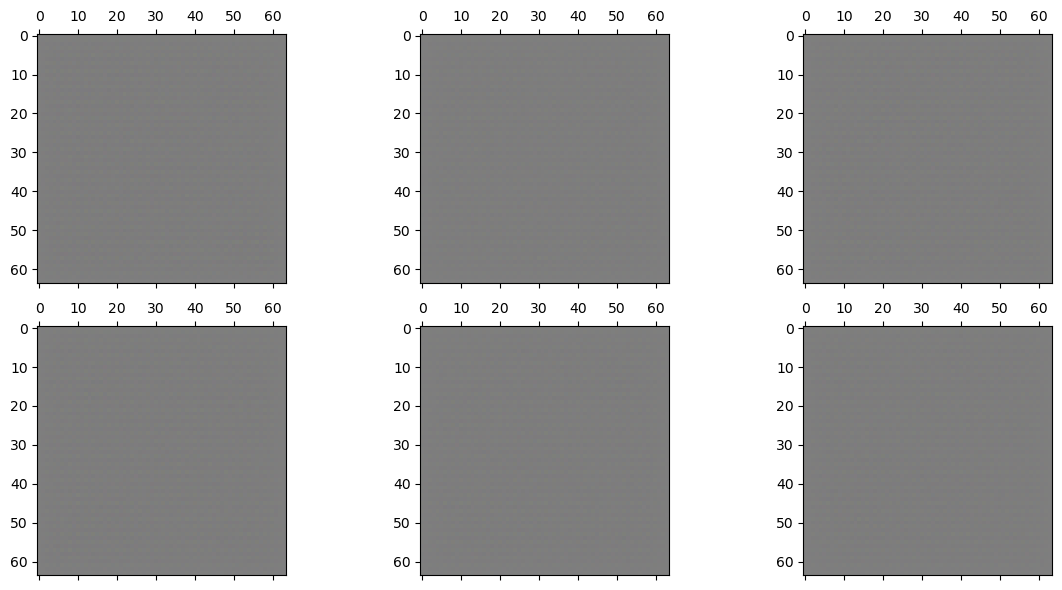

1/1 [==============================] - 2s 2s/step


In [ ]:
train(gen_model, dis_model, gan_model, data, latent_dim)

In [ ]:
gen_model.save(main_dir+"/data/models/007a_Generator_2k.h5")
dis_model.save(main_dir+"/data/models/007a_Discriminator_2k.h5")
gan_model.save(main_dir+"/data/models/007a_GAN_2k.h5")